In [1]:
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from sklearn.metrics import r2_score, mean_squared_error
from tool_kit import calc_ccc, accuracy_plot, uncertainty_plot
from sklearn.model_selection import cross_val_score, KFold, GroupKFold
from mapie.regression import MapieRegressor

import pandas as pd
import numpy as np
import warnings
import joblib
warnings.filterwarnings('ignore')

# read in necessary material
folder = '/mnt/inca/soc_eu_model'
test = pd.read_csv(f'{folder}/data/004.0_validate.pnts_oc.csv',low_memory=False)
train = pd.read_csv(f'{folder}/data/005.0_train.pnts_oc.csv',low_memory=False)

# target variable
tgt = 'oc_log1p'

# covariates
meta_info = ['id','lat','lon','time','ref','nuts0','geometry','tile_id']
meta_prop = ['oc','ph_h2o','ph_cacl2','bulk_density','clay','silt','sand','caco3','N','K','P','CEC','EC']
meta_qa = [i+'_qa' for i in meta_prop]
meta = meta_info + meta_prop + meta_qa + [tgt] + ['oc']
covs = [i for i in train.columns if i not in meta]

with open(f'{folder}/SOC-EU/features/002_selected.covar_rank.freq.txt', 'r') as file:
    lines = file.readlines()
covs_rank = [line.strip() for line in lines]

# dataset
train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')

# spatial cross validation
spatial_cv_column = 'tile_id'
cv = GroupKFold(n_splits=5)

/home/opengeohub/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### build the binary classifier to determine mineral or organic soil

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import HalvingGridSearchCV, cross_val_predict
from sklearn.externals import joblib

# Sample the training data
sampled_train = train.groupby(spatial_cv_column, group_keys=False).apply(lambda x: x.sample(min(len(x), 5)))

# Create binary target for classification of mineral and organic soil
sampled_train['oc_class'] = (sampled_train[tgt] > 5.02).astype(int)

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [200, 500, 800, 1000],
    'max_depth': [10, 20, 30],
    'max_features': [0.3, 0.5, 0.7, 'log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up HalvingGridSearchCV for hyperparameter tuning
tune_rf = HalvingGridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=90),
    param_grid=param_grid,
    scoring='f1',  # Use F1 score as the scoring metric
    n_jobs=90,
    cv=5,
    verbose=1
)

# Perform hyperparameter tuning
print(f'Starting parameter fine tuning for RandomForestClassifier, training size: {len(sampled_train)}')
tune_rf.fit(sampled_train[covs], sampled_train['oc_class'])

print("Finish fine tuning\nBest parameters found: ", tune_rf.best_params_)
joblib.dump(tune_rf.best_params_, f'{folder}/SOC-EU/model/test_best.params_classifier.joblib')
joblib.dump(tune_rf.best_estimator_, f'{folder}/SOC-EU/model/test_model_classifier.joblib')

rfc = tune_rf.best_estimator_
# Cross-validate and fit the classifier using the best parameters
remaining_train = train.loc[~train.index.isin(sampled_indices)]
y_pred = rfc.predict(remaining_train[covs])

# Calculate metrics
precision = precision_score(sampled_train['oc_class'], y_pred)
recall = recall_score(sampled_train['oc_class'], y_pred)
f1 = f1_score(sampled_train['oc_class'], y_pred)

# Save the trained classifier
joblib.dump(rfc, f'{folder}/SOC-EU/model/012_model_mineral.organic.classifier.joblib')

# Print metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [2]:
# organic soil: contain at least 30% SOM, which is around 150 g/kg SOC (factor=2), or 174 g/kg SOC (factor=1.725)
# np.log1p(174) = 5.16, np.log1p(150) = 5.02
# by observing the sorted_plot in the previous tests, I will use oc_log1p=5 as a split between mineral and organic soils here

sampled_train = train.groupby(spatial_cv_column, group_keys=False).apply(lambda x: x.sample(min(len(x), 5))) # 44% data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

# Step 1: Create binary target for classification of mineral and organic soil
sampled_train['oc_class'] = (sampled_train[tgt] > 5.02).astype(int)

classifier = RandomForestClassifier(random_state=42,n_jobs=90)
y_pred_cv = cross_val_predict(classifier, sampled_train[covs], sampled_train['oc_class'], cv=5)
classifier.fit(sampled_train[covs], sampled_train['oc_class'])

# Calculate metrics
precision = precision_score(sampled_train['oc_class'], y_pred_cv)
recall = recall_score(sampled_train['oc_class'], y_pred_cv)
f1 = f1_score(sampled_train['oc_class'], y_pred_cv)

joblib.dump(classifier, f'{folder}/SOC-EU/model/012_model_mineral.organic.classifier.joblib')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.37
Recall: 0.14
F1 Score: 0.20


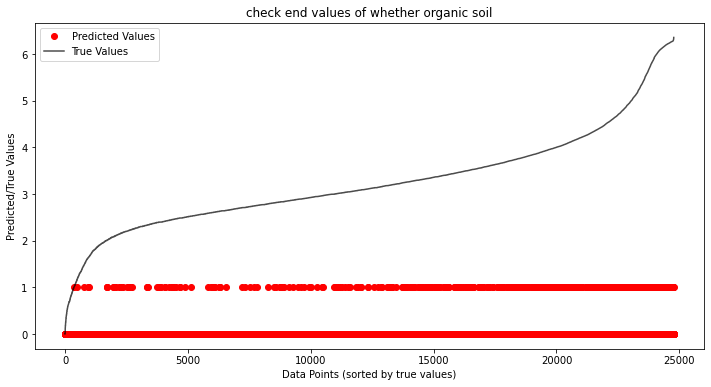

In [3]:
from tool_kit import sorted_plot
sorted_plot(sampled_train[tgt], y_pred_cv, 'whether organic soil')

In [ ]:
# Step 2: Train separate regression models
# Model for tgt <= 5.02
reg_low = LinearRegression()
reg_low.fit(X_train[train_preds_class == 0], y_train[train_preds_class == 0])

# Model for tgt > 5.02
reg_high = LinearRegression()
reg_high.fit(X_train[train_preds_class == 1], y_train[train_preds_class == 1])

# Step 3: Combine models for predictions
# First, predict the class on the test set
test_preds_class = classifier.predict(X_test)

# Apply appropriate regression model based on predicted class
final_predictions = np.where(test_preds_class == 0, reg_low.predict(X_test), reg_high.predict(X_test))

# Evaluation
print("Classifier Accuracy:", accuracy_score(y_test_class, test_preds_class))
print("Regression MSE:", mean_squared_error(y_test, final_predictions))

# This setup uses basic models. Consider tuning and using more complex models based on your data characteristics.


In [15]:
np.log1p(150)

5.017279836814924

<Axes: >

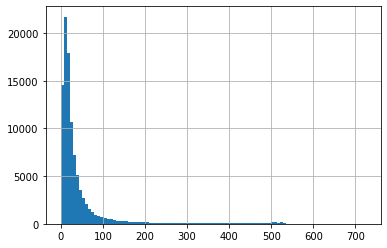

In [14]:
train['oc'].hist(bins=100)

In [16]:
np.expm1(1.8)

5.0496474644129465

In [ ]:
#In parallel with ensemble machine learning (EML), 
# Robert and I are also testing [hierarchical modelling](https://www.sciencedirect.com/science/article/pii/S0016706123002562) 
# to address the issue of underestimating high SOC values.
